# Lab 1c: Introduction to Curve Fitting
### Wellesley College, Physics 202 Lab, Fall 2016
### Lauri Wardell and Jerome Fung

Let's recap what you've accomplished so far:

* You've installed a scientific Python distribution and become familiar with the basics of Jupyter notebooks
* You've gotten some practice working with numpy arrays.
* You've learned how to write functions.
* You've learned how to make plots using matplotlib.

We will now draw on those skills as we introduce *curve fitting*. In this tutorial, you will

* Be introduced to the theory of least-squares fitting
* Become able to distinguish between linear least squares problems and nonlinear least squares problems
* Learn to use a nonlinear least squares fitting routine, `scipy.optimize.curve_fit`.

We first begin with the usual import statements.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize # we'll use this now
%matplotlib inline

## Theoretical Background
### Least Squares Fitting

Suppose we have a set of $n$ points $\{ x_i, y_i \}$ from experimental measurements. We are usually seeking to fit some mathematical function to the experimentally measured points. The function can be written in a general way as

$$ f(x; p_j) $$

where the $p_j$ represent a set of $m$ unknown *parameters*. 

As an example, consider a linear function:

$$ f(x; \{A, B\}) = A + Bx$$

Here, there are two parameters to be determined by fitting, the y-intercept $A$ and the slope $B$.

The general objective in the curve-fitting problem is to find optimal values for the parameters $p_{j,opt}$ such that $f(x_i; p_{j,opt})$ is a "best fit" to the measured points $y_i$. How can "best fit" be defined in a quantitative way? One way is by considering the *residuals* for some set of parameters $p_j$. For a given set $p_j$ and data point $x_i$, the $i$th residual $r_i$ is defined such that

$$r_i = y_i - f(x_i; p_j)$$

Note that $r_i=0$ if the value $f(x_i;p_j)$ exactly equals the measured point $y_i$. 

The most common definition of $p_{j,opt}$ is that they are the set of $p_j$ such that the quantity $\chi^2$ (chi-squared), defined as 

$$\chi^2 \equiv \sum_{i}^n r_i^2 $$

is *minimized*. Determining the *best-fit parameters* $p_{j,opt}$ using this criterion is called *least-squares fitting*.

***Exercise 6***

Explain why is it not a good idea to minimize the sum of the residuals

$$\sum_{i}^n r_i$$

and why minimizing $\chi^2$ is preferable.

### Linear vs. nonlinear least squares

There are two cases of the least-squares fitting problem that are worth distinguishing:

**Linear least squares**: The function $f$ for which you are determining unknown parameters is *linear* in the parameters. That is, $f(x;p_j)$ can be written in the form

$$f(x; p_j) = p_0 + p_1g_1(x) + p_2g_2(x) + p_3g_3(x) + \ldots $$

where the $g_k(x)$ are arbitrary functions of the measurements $x$. In other words, each parameter $p_j$ appears in $f$ at most once, appears by itself, and is raised to the power 1.

The simplest example of a function that is linear in the parameters is the linear function

$$f(x; \{A,B\}) = A + Bx$$

discussed above. But a function that is *linear in the parameters* need not be linear in $x$. For instance,

$$f(x; \{p_0, p_1, p_2\}) = p_0 + p_1x + p_2x^2 $$

is linear in the parameters even though it is quadratic in $x$.

A formal analytic solution is possible to the general linear least squares problem. See Taylor, "An Introduction to Error Analysis," Ch. 8 for a detailed discussion of the analytic solution for the important special case of a line: $f = A + Bx$. 

**Nonlinear least squares**: The function $f$ is not linear in the parameters.

The general case of nonlinear least squares cannot be solved analytically and requires a numerical solution. Fortunately, `scipy.optimize.curve_fit` is a robust nonlinear least squares fitter. Since linear least squares is a special case of the more general nonlinear least squares problem, any algorithm that can handle nonlinear least squares problems can also handle linear least squares problems.

### Linearization
Note that some nonlinear least squares problems can be *linearized*. For instance, suppose your data could be modeled by 

$$ y = p_0\exp\left( -\frac{t}{p_1}  \right)$$

Taking the natural logarithm of both sides gives

$$ \ln y = \ln p_0 - \frac{t}{p_1} $$

You could then fit a straight line to the points $(t_i, \ln y_i)$ with y-intercept $\ln p_0$ and slope $-1/p_1$ -- something you could do with linear least squares. However, the uncertainties in the measured $y$ values are tricky to handle correctly in this way (see further discussion in Taylor, pp. 194-196). We will therefore not pursue linearization further in this first tutorial and laboratory exercise.

In the rest of this tutorial, we'll learn to use `scipy.optimize.curve_fit` on a simple fitting problem.

## Using `scipy.optimize.curve_fit`

Let's consider a hypothetical experiment to test Hooke's law for a spring:

$$ \left|\vec{F}_{spring}\right| = ks$$

where $s$ is the distance the spring is stretched and $k$ is the spring constant. Our goal will be to determine the spring constant $k$. Suppose you carry out this experiment by attaching a spring to a force sensor. You record the displacement of the end of the spring and measure the force exerted by the spring at each displacement. Imagine that you've collected the following data:

|Displacement (m)| Force (N) |
|------|------|
| 0.03 | 0.25 |
| 0.05 | 0.85 |
| 0.07 | 1.20 |
| 0.10 | 1.90 |
| 0.12 | 2.50 |
| 0.14 | 2.95 |
| 0.16 | 3.50 |
| 0.18 | 4.10 |
| 0.20 | 4.80 |

Let's begin the analysis by making appropriate data arrays. For a small number of data points like this, it is easiest to input data by hand. In subsequent sessions we'll discuss other ways to read data from files.

In [2]:
displacements = np.array([0.03, 0.05, 0.07, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20]) # meters
forces = np.array([0.25, 0.85, 1.20, 1.90, 2.50, 2.95, 3.50, 4.10, 4.80]) # newtons

Now let's make a quick plot. It is good to check visually that the data seems to be described by the function we want to fit (according to Hooke's law, a straight line.)

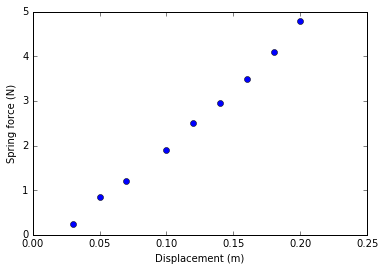

In [3]:
plt.plot(displacements, forces, 'bo')
plt.xlabel('Displacement (m)')
plt.ylabel('Spring force (N)')

The graph looks basically linear, which is good. Notice, however, that it does not look as though the $y$ intercept is 0, which is what we'd expect if the measured displacement was equal to the distance the spring stretched. Perhaps there was some systematic offset in our measurement of the displacement or the zeroing of the force sensor. For now, we'll deal with this by fitting a line with a nonzero y-intercept

$$f(x; \{A, B\}) = A + Bx$$

to the data. To be clear, here $x$ will be our measured displacements.

To use `scipy.optimize.curve_fit`, we need to first define a *model function* that takes the independent variable (in our case, the displacements) as its first argument and the fit parameters as the remaining arguments. The model function needs to return the model's prediction for the dependent variable (in our case, the measured forces). We do that in the code cell below:

In [4]:
def straight_line_model(x, A, B):
    '''
    Model function for a straight-line fit with y-intercept A and slope B.
    '''
    return A + B * x

Now we can call `scipy.optimize.curve_fit`. For simple usage, we can do the following:

```python
popt, pcov = scipy.optimize.curve_fit(straight_line_model, displacements, forces)
```

Breaking this down:

* The first argument to `curve_fit` is the name of the model function, here `straight_line_model`.
* The second argument is an array containing the independent variable (here, our spring displacements).
* The third argument is an array containing the measured dependent variable (here, our measured forces).
* The first argument returned from `curve_fit`, `popt`, is an array of best-fit parameters $p_{j,opt}$ found by the `curve_fit` algorithm.
* The second argument returned from `curve_fit`, `pcov`, is the *covariance matrix*. We won't give a formal statistical definition here except to say that the uncertainty in the parameters can be determined from this matrix.

(If you want more details, here is [the official documentation for curve_fit](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). If you want to know more about the default algorithm used by `curve_fit`, the Levenberg-Marquardt algorithm, here's a link to the [Wikipedia entry](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm). You can also read about it in Section 15.5 of the canonical numerical methods text "Numerical Recipes in C" by Press et al., accessible [here](http://apps.nrbook.com/c/index.html).)

Here we go, then:

In [5]:
popt, pcov = scipy.optimize.curve_fit(straight_line_model, displacements, forces)
print('best-fit parameters: ', popt)
print('covariance matrix: ')
print(pcov)

best-fit parameters:  [ -0.58207434  25.98920863]
covariance matrix: 
[[ 0.00753446 -0.05263595]
 [-0.05263595  0.45116529]]


(Notice that `pcov` is not quite like the arrays we've previously worked with: it is a 2-dimensional array. We'll learn more about those another time.)

We have therefore determined that the best-fit intercept is -0.582 m and the best-fit slope is 26.0 N/m. It turns out that the square root of the diagonal elements of the covariance matrix `pcov` gives the uncertainty in the best-fit parameters (assuming the experimental uncertainties in the measured force values are all the same). We can calculate this as follows:

In [6]:
popt_uncertainties = np.sqrt(np.diag(pcov)) # get the diagonal elements then take sqrt
print('uncertainties: ', popt_uncertainties)

uncertainties:  [ 0.08680127  0.67168839]


We can therefore report 

$$A = -0.58 \pm 0.09 \ \textrm{m}$$

$$B = 26.0 \pm 0.7 \ \textrm{N/m}$$

as the best-fit slope and intercept determined by the fit.

We also want to check that the best-fit parameter values indeed fit the data. Again, it is useful to make a plot to check:

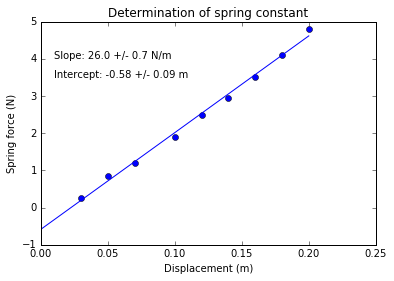

In [7]:
# calculate best fit model values
displacement_for_plot = np.linspace(0, displacements.max(), 50)
best_fit_line = straight_line_model(displacement_for_plot, popt[0], popt[1])

# plot
plt.plot(displacements, forces, 'bo')
plt.plot(displacement_for_plot, best_fit_line, 'b') # plot with a solid line
plt.xlabel('Displacement (m)')
plt.ylabel('Spring force (N)')
plt.title('Determination of spring constant')
plt.text(0.01, 4, 'Slope: 26.0 +/- 0.7 N/m')
plt.text(0.01, 3.5, 'Intercept: -0.58 +/- 0.09 m')

In the last two lines I wrote the best-fit parameters on the graph using `plt.text()`. The first argument to `plt.text()` is the $x$ coordinate of the printed text (in the units of the graph axes), the second is the $y$ coordinate, and the third is the string to be printed. (There are fancier ways to do this, but for now the quick-and-dirty way illustrated above will do.)

It can also be useful to plot the residuals:

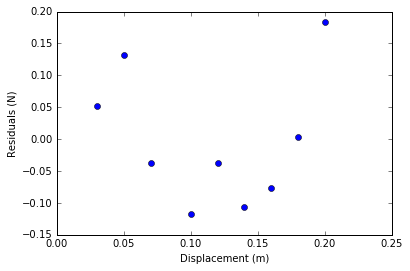

In [8]:
plt.plot(displacements, forces - straight_line_model(displacements, popt[0], popt[1]), 'bo')
plt.xlabel('Displacement (m)')
plt.ylabel('Residuals (N)')

In general, the residuals should look random if the model describes the data well and each measurement was subject to some purely random error. In this case there seems to be a systematic trend -- the residuals are positive for small and large displacements, and negative in the middle. Often, the presence of systematic trends in the residuals suggests that the model we fit is not entirely appropriate. We might consider investigating further (perhaps the spring is not Hookean), but for the purpose of this tutorial we'll choose to stop here.

### Giving `scipy.optimize.curve_fit` initial parameter values

The Levenberg-Marquardt algorithm behind `scipy.optimize.curve_fit` requires some initial initial guess for the best-fit parameter values. The default initial guess values (if you don't specify your own) are 1 for all your parameters. This often works (as in our examples above). But, sometimes the curve fitter will not converge to physically sensible values if the initial guess values are very far off from the best-fit values. It can then be necessary to provide estimates of the initial guess values. Here's how you can do it (using the Hooke's law data above):

In [9]:
# Define an array with initial guess values
guess = np.array([20., -1.])

popt_guess, pcov_guess = scipy.optimize.curve_fit(straight_line_model, displacements, forces,
                                                 p0 = guess)
print('best-fit parameters: ', popt_guess)
print('covariance matrix: ')
print(pcov_guess)

best-fit parameters:  [ -0.58207434  25.98920864]
covariance matrix: 
[[ 0.00753446 -0.05263595]
 [-0.05263595  0.45116528]]


You have now been introduced to a very powerful and general framework for curve fitting. Unlike the linear regressions built into most spreadsheet programs, you can now use `scipy` to perform fits of much more general model functions. We will be drawing on this skill throughout the Physics 202 lab, and you will also find this useful in our advanced laboratory course, Physics 310.

***Exercise 7***

As part of your first lab on determining the specific heat of STP, fit Newton's Law of Cooling to your data with `scipy.optimize.curve_fit`. 